## Re-analysis of Park et al. findings using gene expression-based mutation signatures

In [Park et al. 2021](https://www.nature.com/articles/s41467-021-27242-3), the authors study interactions between point mutations and CNVs in TCGA data. Essentially, they do an overrepresentation analysis to identify genes/cancer types that have more samples with _both_ a point mutation and a CNV than expected by chance, implying that these genes tend to require "two hits" (the point mutation and the CNV in this case) to be activated (oncogenes) or inactivated (tumor suppressors).

Here, we want to take the genes/cancer types they identified, and analyze the functional effects in the context of our mutation prediction classifiers. Our hypothesis is that in the "two-hit" genes, samples with "two hits" (a point mutation and a CNV) will have a higher predicted mutation probability than samples with zero or one hit.

In [1]:
from pathlib import Path
import pickle as pkl

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys; sys.path.append('..')
import config as cfg
import utilities as ut

%load_ext autoreload
%autoreload 2

In [2]:
# park et al. geneset info
park_loss_data = cfg.data_dir / 'park_loss_df.tsv'
park_gain_data = cfg.data_dir / 'park_gain_df.tsv'

# park et al. significant gene info
park_loss_sig_data = cfg.data_dir / 'park_loss_df_sig_only.tsv'
park_gain_sig_data = cfg.data_dir / 'park_gain_df_sig_only.tsv'

# park et al. gene/cancer type predictions
park_preds_dir = cfg.data_dir / 'park_genes_all_preds'

# mutation and copy number data
pancancer_pickle = Path('/home/jake/research/mpmp/data/pancancer_data.pkl')

### Load mutation info

For now, just use binary mutation status from the pancancer repo. In the future we could pull more granular info from MC3, but it would take some engineering of `1_get_mutation_counts` to do this for lots of genes.

In [3]:
park_loss_df = pd.read_csv(park_loss_data, sep='\t', index_col=0)
park_loss_df.head()

,Gene,Tissue,Effect,Pval,FDR,LogFDR,Target,classification
ACVR1_UCEC,ACVR1,UCEC,0.000000,0.997445,0.681521,0.166514,B_Target,Oncogene
ACVR2A_COADREAD,ACVR2A,COADREAD,0.000000,0.997631,0.681315,0.166646,B_Target,TSG
ACVR2A_LIHC,ACVR2A,LIHC,-1.000178,0.040008,0.122307,0.912515,B_Target,TSG
AJUBA_HNSC,AJUBA,HNSC,-0.936050,0.008733,0.045816,1.338886,A_Hit,TSG
AKT1_BRCA,AKT1,BRCA,0.000000,0.997163,0.681829,0.166318,B_Target,Oncogene


In [4]:
park_gain_df = pd.read_csv(park_gain_data, sep='\t', index_col=0)
park_gain_df.head()

,Gene,Tissue,Effect,Pval,FDR,LogFDR,Target,classification
ACVR1_UCEC,ACVR1,UCEC,-0.482699,0.370095,0.571956,0.242630,B_Target,Oncogene
ACVR2A_COADREAD,ACVR2A,COADREAD,0.187531,0.753981,0.780954,0.107369,B_Target,TSG
ACVR2A_LIHC,ACVR2A,LIHC,0.163421,0.834858,0.821548,0.085362,B_Target,TSG
AJUBA_HNSC,AJUBA,HNSC,0.711518,0.026392,0.147049,0.832509,B_Target,TSG
AKT1_BRCA,AKT1,BRCA,0.535765,0.092176,0.312738,0.504805,B_Target,Oncogene


In [5]:
with open(pancancer_pickle, 'rb') as f:
    pancancer_data = pkl.load(f)

In [6]:
# get (binary) mutation data
# 1 = observed non-silent mutation in this gene for this sample, 0 otherwise
mutation_df = pancancer_data[1]
print(mutation_df.shape)
mutation_df.iloc[:5, :5]

(9074, 20938)


,5S_rRNA,A1BG,A1CF,A2M,A2ML1
SAMPLE_BARCODE,,,,,
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0
TCGA-02-2483-01,0,0,0,0,0
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


### Load copy number info

Get copy loss/gain info directly from GISTIC "thresholded" output. This should be the same as (or very similar to) what the Park et al. study uses.

In [7]:
# we use the data source and preprocessing code from the pancancer repo, here:
# https://github.com/greenelab/pancancer/blob/d1b3de7fa387d0a44d0a4468b0ac30918ed66886/scripts/initialize/process_copynumber.py#L21

copy_thresh_df = (
    pd.read_csv(cfg.data_dir / 'pancan_GISTIC_threshold.tsv',
                sep='\t', index_col=0)
      .drop(columns=['Locus ID', 'Cytoband'])
)
copy_thresh_df.columns = copy_thresh_df.columns.str[0:15]

# thresholded copy number includes 5 values [-2, -1, 0, 1, 2], which
# correspond to "deep loss", "moderate loss", "no change",
# "moderate gain", and "deep gain", respectively.
print(copy_thresh_df.shape)
copy_thresh_df.iloc[:5, :5]

(25128, 10713)


,TCGA-OR-A5J1-01,TCGA-OR-A5J2-01,TCGA-OR-A5J3-01,TCGA-OR-A5J4-01,TCGA-OR-A5J5-01
Gene Symbol,,,,,
ACAP3,0,0,0,1,0
ACTRT2,0,0,0,1,0
AGRN,0,0,0,1,0
ANKRD65,0,0,0,1,0
ATAD3A,0,0,0,1,0


In [8]:
sample_freeze_df = pancancer_data[0]
copy_samples = list(
    set(sample_freeze_df.SAMPLE_BARCODE)
    .intersection(set(copy_thresh_df.columns))
)
print(len(copy_samples))

9068


In [9]:
# make sure we're not losing too many samples, a few is fine
print(sorted(set(sample_freeze_df.SAMPLE_BARCODE) - set(copy_thresh_df.columns)))

['TCGA-06-0152-02', 'TCGA-06-0171-02', 'TCGA-06-0221-02', 'TCGA-14-0736-02', 'TCGA-ER-A19T-01', 'TCGA-ER-A2NF-01']


In [10]:
copy_thresh_df = (copy_thresh_df
    .T
    .loc[sorted(copy_samples)]
    .fillna(0)
    .astype(int)
)

print(copy_thresh_df.shape)
copy_thresh_df.iloc[:5, :5]

(9068, 25128)


Gene Symbol,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,1,1,1,1,1
TCGA-02-2483-01,-1,-1,-1,-1,-1
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


In [11]:
# here, we want to use "moderate" and "deep" loss/gain to define CNV
# loss/gain (to match Park et al.)
#
# note that this is different to the more conservative approach of using
# "deep loss/gain" only as in our classifiers

copy_loss_df = (copy_thresh_df
    .replace(to_replace=[1, 2], value=0)
    .replace(to_replace=[-1, -2], value=1)
)
print(copy_loss_df.shape)
copy_loss_df.iloc[:5, :5]

(9068, 25128)


Gene Symbol,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0
TCGA-02-2483-01,1,1,1,1,1
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


In [12]:
copy_gain_df = (copy_thresh_df
    .replace(to_replace=[-1, -2], value=0)
    .replace(to_replace=[1, 2], value=1)
)
print(copy_gain_df.shape)
copy_gain_df.iloc[:5, :5]

(9068, 25128)


Gene Symbol,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,1,1,1,1,1
TCGA-02-2483-01,0,0,0,0,0
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


At this point, the copy number data should be binary - in the copy gain data, each sample either has a copy number amplification or not in each gene, and in the copy loss data, each sample either has a copy number loss or not in each gene.

Some samples seem to have copy number changes in almost every gene. This could actually be the case for some tumors, e.g. due to widespread chromosomal instability, but we'll take a look at this in the future.

### Classify genes/cancer types into "classes"

In [the Park et al. paper](https://www.nature.com/articles/s41467-021-27242-3#Sec4), they describe 4 "classes" of driver genes:

1. Genes that function exclusively as one-hit drivers, no significant co-occurrence with CNAs
2. Genes that interact with CNA loss in at least one cancer type - "two-hit loss" drivers (i.e. classical tumor suppressors)
3. Genes that interact with CNA gain in at least one cancer type - "two-hit gain" drivers (for some examples/explanation of "two-hit" oncogenes, see [this paper](https://www.nature.com/articles/s41586-020-2175-2))
4. Genes that interact with both CNA loss and CNA gain across multiple cancer types - "two-hit loss and gain" drivers

Here, we label each of the genes from the Park et al. data with their "class", since we want to segment our analyses in this way too.

In [13]:
park_loss_sig_df = pd.read_csv(park_loss_sig_data, sep='\t', index_col=0)
park_gain_sig_df = pd.read_csv(park_gain_sig_data, sep='\t', index_col=0)

class_4_ids = (
    set(park_loss_sig_df.index.unique()).intersection(
    set(park_gain_sig_df.index.unique())
))

class_2_ids = set(park_loss_sig_df.index.unique()) - class_4_ids
class_3_ids = set(park_gain_sig_df.index.unique()) - class_4_ids

class_1_ids = (
    set(park_loss_df.index.unique()) - (
        class_4_ids.union(class_2_ids, class_3_ids)
    )
)
print(len(park_loss_df.index.unique()))
print('class 1:', len(class_1_ids))
print('class 2:', len(class_2_ids))
print('class 3:', len(class_3_ids))
print('class 4:', len(class_4_ids))
print(sorted(class_4_ids))

452
class 1: 354
class 2: 68
class 3: 19
class 4: 11
['ARID1A_UCEC', 'CTNNB1_UCEC', 'EPAS1_PCPG', 'NRAS_SKCM', 'PPP2R1A_UCEC', 'TP53_BLCA', 'TP53_BRCA', 'TP53_GBM', 'TP53_HNSC', 'TP53_SARC', 'TP53_UCEC']


In [14]:
def id_to_class(i):
    if i in class_2_ids:
        return 'class 2'
    elif i in class_3_ids:
        return 'class 3'
    elif i in class_4_ids:
        return 'class 4'
    else:
        return 'class 1'

loss_class = {i: id_to_class(i) for i in park_loss_df.index.unique()}

park_loss_df['class'] = park_loss_df.index.map(loss_class)
print(park_loss_df['class'].unique())
park_loss_df.head()

['class 1' 'class 2' 'class 4' 'class 3']


,Gene,Tissue,Effect,Pval,FDR,LogFDR,Target,classification,class
ACVR1_UCEC,ACVR1,UCEC,0.000000,0.997445,0.681521,0.166514,B_Target,Oncogene,class 1
ACVR2A_COADREAD,ACVR2A,COADREAD,0.000000,0.997631,0.681315,0.166646,B_Target,TSG,class 1
ACVR2A_LIHC,ACVR2A,LIHC,-1.000178,0.040008,0.122307,0.912515,B_Target,TSG,class 1
AJUBA_HNSC,AJUBA,HNSC,-0.936050,0.008733,0.045816,1.338886,A_Hit,TSG,class 2
AKT1_BRCA,AKT1,BRCA,0.000000,0.997163,0.681829,0.166318,B_Target,Oncogene,class 1


In [15]:
gain_class = {i: id_to_class(i) for i in park_gain_df.index.unique()}

park_gain_df['class'] = park_gain_df.index.map(gain_class)
print(park_gain_df['class'].unique())
park_gain_df.head()

['class 1' 'class 2' 'class 4' 'class 3']


,Gene,Tissue,Effect,Pval,FDR,LogFDR,Target,classification,class
ACVR1_UCEC,ACVR1,UCEC,-0.482699,0.370095,0.571956,0.242630,B_Target,Oncogene,class 1
ACVR2A_COADREAD,ACVR2A,COADREAD,0.187531,0.753981,0.780954,0.107369,B_Target,TSG,class 1
ACVR2A_LIHC,ACVR2A,LIHC,0.163421,0.834858,0.821548,0.085362,B_Target,TSG,class 1
AJUBA_HNSC,AJUBA,HNSC,0.711518,0.026392,0.147049,0.832509,B_Target,TSG,class 2
AKT1_BRCA,AKT1,BRCA,0.535765,0.092176,0.312738,0.504805,B_Target,Oncogene,class 1


### Retrieve and format per-sample information

We want to generate a dataframe with the following information:

* Sample ID, gene/tissue
* Gene classification (oncogene/TSG)
* Mutation status (binary) for sample in gene
* CNV status (binary) for sample in gene, gain/loss for oncogene/TSG respectively
* Predicted probability of mutation/CNV from our gene expression classifier for the given gene/tissue

In [16]:
from scipy.special import expit

def get_info_for_gene_and_tissue(identifier, classification):
    """Given a gene and tissue, load the relevant classifier results and
    mutation information, and return a dataframe.
    
    'status' is what we will segment our plots by: 'none' == neither a point
    mutation or CNV observed for the given sample, 'one' == either a point
    mutation or CNV but not both, 'both' == both point mutation and CNV
    """
    gene, tissue = identifier.split('_')
    preds_file = park_preds_dir / '{}_expression_False_raw_preds.tsv'.format(identifier)
    preds_df = pd.read_csv(preds_file, sep='\t', skiprows=1, index_col=0,
                           names=['score', 'positive_prob'])
    preds_df.index.name = 'sample_id'
    
    # get predictions for identifier
    preds_df['identifier'] = identifier
    # preds_df['positive_prob'] = expit(preds_df.score)
    preds_df.drop(columns=['score'], inplace=True)
    
    # get mutation status for samples
    preds_df['mutation_status'] = mutation_df.loc[preds_df.index, gene]
    
    # get copy status for samples
    if classification == 'TSG':
        samples = preds_df.index.intersection(copy_loss_df.index)
        copy_status = copy_loss_df.loc[samples, gene]
    elif classification == 'Oncogene':
        samples = preds_df.index.intersection(copy_gain_df.index)
        copy_status = copy_gain_df.loc[samples, gene]
    preds_df['copy_status'] = copy_status
        
    def status_from_mut_info(row):
        if row['mutation_status'] == 1 and row['copy_status'] == 1:
            return 'both'
        elif row['mutation_status'] == 1 or row['copy_status'] == 1:
            return 'one'
        else:
            return 'none'
        
    preds_df['status'] = preds_df.apply(status_from_mut_info, axis=1)
    
    return preds_df

In [17]:
plot_id = 'MAP3K1_UCEC'
df = get_info_for_gene_and_tissue(plot_id, 'TSG')
print(df.mutation_status.isna().sum())
print(df.copy_status.isna().sum())
df.head()

0
0


,positive_prob,identifier,mutation_status,copy_status,status
sample_id,,,,,
TCGA-4E-A92E-01,0.0,MAP3K1_UCEC,0,0,none
TCGA-A5-A0GB-01,0.0,MAP3K1_UCEC,0,0,none
TCGA-A5-A0GJ-01,0.0,MAP3K1_UCEC,0,1,one
TCGA-A5-A0GM-01,0.0,MAP3K1_UCEC,0,0,none
TCGA-A5-A0GW-01,0.0,MAP3K1_UCEC,0,0,none


Text(0.5, 1.0, 'Distribution of positive probabilities for MAP3K1_UCEC')

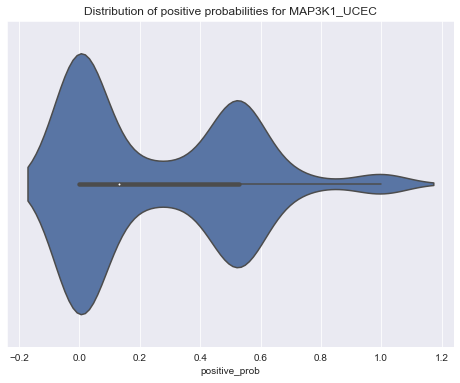

In [18]:
sns.set({'figure.figsize': (8, 6)})
sns.violinplot(x=df.positive_prob)
plt.title('Distribution of positive probabilities for {}'.format(plot_id))

Text(0.5, 1.0, 'MAP3K1_UCEC')

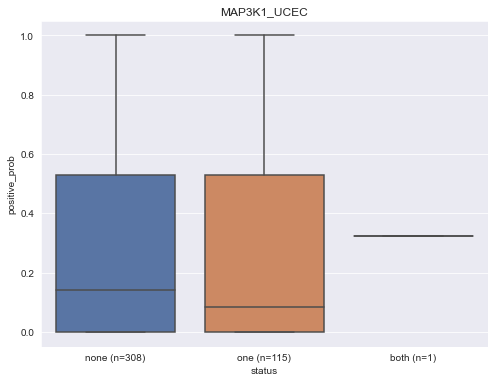

In [19]:
order = ['none', 'one', 'both']
sns.set({'figure.figsize': (8, 6)})
sns.boxplot(data=df, x='status', y='positive_prob',
            order=order)

def get_counts(status):
    un = np.unique(status, return_counts=True)
    return {s: c for s, c in zip(*un)}

count_map = get_counts(df.status.values)
plt.xticks(np.arange(3),
           ['{} (n={})'.format(l, count_map[l]) for l in order])
plt.title(plot_id)

### Averages across each "class" of genes

In [20]:
park_df = pd.concat((park_loss_df, park_gain_df))
print(park_df.shape)
park_df.head()

(906, 9)


,Gene,Tissue,Effect,Pval,FDR,LogFDR,Target,classification,class
ACVR1_UCEC,ACVR1,UCEC,0.000000,0.997445,0.681521,0.166514,B_Target,Oncogene,class 1
ACVR2A_COADREAD,ACVR2A,COADREAD,0.000000,0.997631,0.681315,0.166646,B_Target,TSG,class 1
ACVR2A_LIHC,ACVR2A,LIHC,-1.000178,0.040008,0.122307,0.912515,B_Target,TSG,class 1
AJUBA_HNSC,AJUBA,HNSC,-0.936050,0.008733,0.045816,1.338886,A_Hit,TSG,class 2
AKT1_BRCA,AKT1,BRCA,0.000000,0.997163,0.681829,0.166318,B_Target,Oncogene,class 1


In [21]:
park_info = []
for identifier in park_df.index:
    try:
        classification = park_df.loc[identifier, 'classification']
        info_df = get_info_for_gene_and_tissue(identifier, classification)
    except ValueError:
        classification = park_df.loc[identifier, 'classification'].values[0]
        info_df = get_info_for_gene_and_tissue(identifier, classification)
    except FileNotFoundError:
        continue
    park_info.append(info_df)
    
park_info_df = pd.concat(park_info)
print(park_info_df.shape)
park_info_df.head()

(308148, 5)


,positive_prob,identifier,mutation_status,copy_status,status
sample_id,,,,,
TCGA-4E-A92E-01,1.558183e-08,ACVR1_UCEC,0,0.0,none
TCGA-A5-A0GB-01,2.734236e-237,ACVR1_UCEC,1,0.0,one
TCGA-A5-A0GJ-01,0.000000e+00,ACVR1_UCEC,0,0.0,none
TCGA-A5-A0GM-01,0.000000e+00,ACVR1_UCEC,0,0.0,none
TCGA-A5-A0GW-01,0.000000e+00,ACVR1_UCEC,0,0.0,none


In [22]:
def id_to_class(identifier):
    if type(park_df.loc[identifier, 'class']) == pd.Series:
        return park_df.loc[identifier, 'class'].values[0]
    else:
        return park_df.loc[identifier, 'class']

park_info_df['class'] = park_info_df['identifier'].apply(id_to_class)
park_info_df.head()

,positive_prob,identifier,mutation_status,copy_status,status,class
sample_id,,,,,,
TCGA-4E-A92E-01,1.558183e-08,ACVR1_UCEC,0,0.0,none,class 1
TCGA-A5-A0GB-01,2.734236e-237,ACVR1_UCEC,1,0.0,one,class 1
TCGA-A5-A0GJ-01,0.000000e+00,ACVR1_UCEC,0,0.0,none,class 1
TCGA-A5-A0GM-01,0.000000e+00,ACVR1_UCEC,0,0.0,none,class 1
TCGA-A5-A0GW-01,0.000000e+00,ACVR1_UCEC,0,0.0,none,class 1


In [23]:
# save park sample-level info to file, we'll use it in later analyses
park_info_df.to_csv(
    cfg.park_info_file, sep='\t'
)

In [24]:
park_info_df.groupby(by=['class']).count()

,positive_prob,identifier,mutation_status,copy_status,status
class,,,,,
class 1,229942,229942,229942,229818,229942
class 2,53758,53758,53758,53726,53758
class 3,15822,15822,15822,15806,15822
class 4,8626,8626,8626,8614,8626


([<matplotlib.axis.XTick at 0x7f66fa6d5970>,
 [Text(0, 0, 'none (n=198346)'),
  Text(1, 0, 'one (n=97184)'),
  Text(2, 0, 'both (n=12618)')])

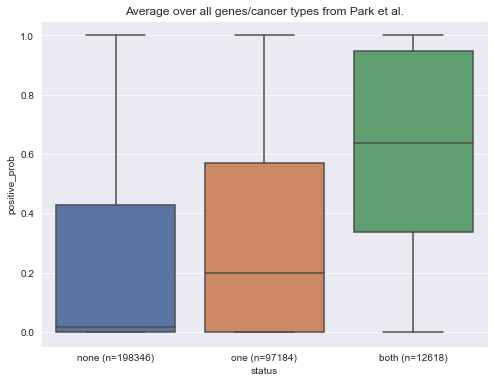

In [25]:
order = ['none', 'one', 'both']
sns.set({'figure.figsize': (8, 6)})
sns.boxplot(data=park_info_df, x='status', y='positive_prob',
            order=order)
plt.title('Average over all genes/cancer types from Park et al.')

count_map = get_counts(park_info_df.status.values)
plt.xticks(np.arange(3),
           ['{} (n={})'.format(l, count_map[l]) for l in order])

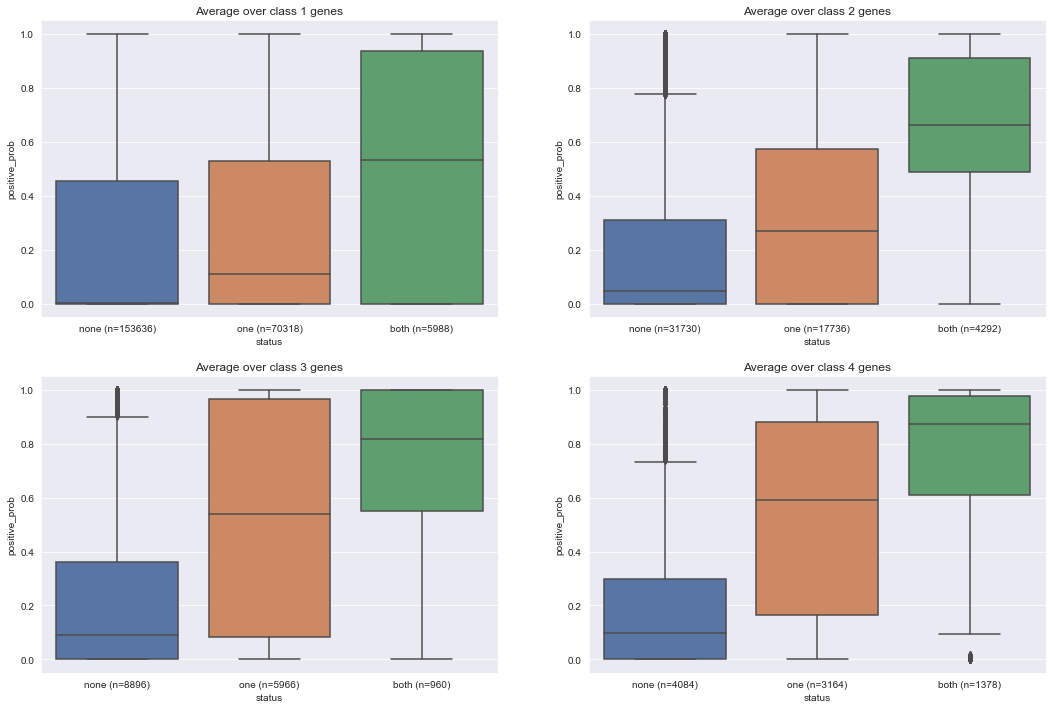

In [26]:
sns.set({'figure.figsize': (18, 12)})
fig, axarr = plt.subplots(2, 2)

for ix, class_label in enumerate(['class 1', 'class 2', 'class 3', 'class 4']):
    ax = axarr[ix // 2, ix % 2]
    plot_df = park_info_df[park_info_df['class'] == class_label]
    sns.boxplot(data=plot_df, x='status', y='positive_prob',
                order=order, ax=ax)
    ax.set_title('Average over {} genes'.format(class_label))
    count_map = get_counts(plot_df.status.values)
    ax.set_xticks(np.arange(3), ['{} (n={})'.format(l, count_map[l]) for l in order])

Looking at the box plots, we can see that in general, the samples with "both" a point mutation and a CNV in the gene of interest tend to score higher using our classifiers than samples with "one" of a point mutation or a CNV. This is despite the fact that our classifiers were trained using all of these samples ("one" or "both") as positive labels.

The next step is to break this down by gene - are there genes/cancer types where the functional effect of the "two hits" is clearer, or less clear? Are there genes where we see "two hits" at the genetic level but no functional effect/classifier difference, or are the sources of information basically redundant?

### Statistical testing for individual gene/cancer type combinations

In [27]:
info_compare_df = ut.test_all(park_info_df)
print(info_compare_df.shape)
print('reject null for:', info_compare_df.reject_null.sum(), '/', info_compare_df.shape[0])
info_compare_df.sort_values(by='corr_pval', ascending=True).head()

(428, 5)
reject null for: 126 / 428


,identifier,delta_mean,p_value,corr_pval,reject_null
395,TP53_BRCA,-0.368699,2.207936e-108,9.449966e-106,True
274,PBRM1_KIRC,-0.548961,7.861292e-83,1.682316e-80,True
65,CDH1_BRCA,-0.352488,1.982232e-66,2.827985e-64,True
354,SETD2_KIRC,-0.576471,3.322392e-63,3.554959e-61,True
192,KEAP1_LUAD,-0.472457,5.094013e-59,4.360475e-57,True


In [28]:
info_compare_df.to_csv(cfg.data_dir / 'info_compare.tsv', sep='\t')

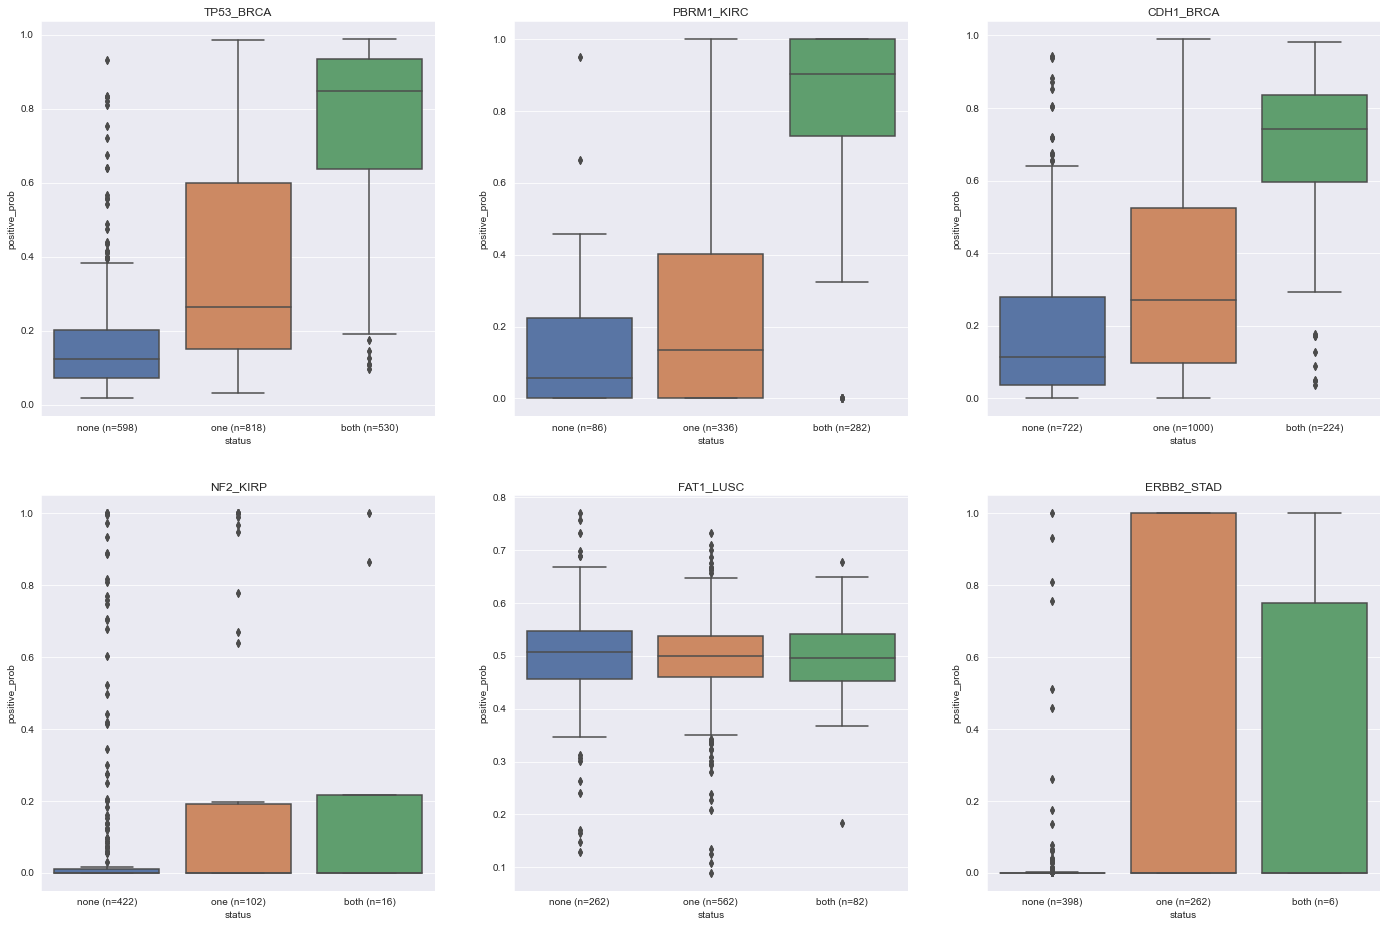

In [29]:
# plot top three most significant
# and top three least significant
order = ['none', 'one', 'both']
def get_counts(status):
    un = np.unique(status, return_counts=True)
    return {s: c for s, c in zip(*un)}

sns.set({'figure.figsize': (24, 16)})
fig, axarr = plt.subplots(2, 3)

valid_df = info_compare_df[info_compare_df.p_value != 1.0]
plot_ids = (
    valid_df.sort_values(by='corr_pval', ascending=True).identifier.tolist()[:3] + 
    valid_df.sort_values(by='corr_pval', ascending=False).identifier.tolist()[:3]
)

for ix, identifier in enumerate(plot_ids):
    ax = axarr[ix // 3, ix % 3]
    plot_df = park_info_df[park_info_df.identifier == identifier]
    sns.boxplot(data=plot_df, x='status', y='positive_prob', order=order, ax=ax)
    count_map = get_counts(plot_df.status.values)
    ax.set_xticks(np.arange(3),
               ['{} (n={})'.format(l, count_map[l]) for l in order])
    ax.set_title(identifier)

### Compare classifier-based statistical testing vs. Park et al statistical testing

In [30]:
pair_df = (info_compare_df
    .merge(park_df, left_on='identifier', right_index=True)
    .rename(columns={'corr_pval': 'classifier_pval',
                     'FDR': 'park_pval'})
)
print(pair_df.shape)
print(pair_df['class'].unique())
print(pair_df.classifier_pval.isna().sum())
pair_df.head()

(858, 14)
['class 1' 'class 2' 'class 4' 'class 3']
0


,identifier,delta_mean,p_value,classifier_pval,reject_null,Gene,Tissue,Effect,Pval,park_pval,LogFDR,Target,classification,class
0,ACVR1_UCEC,-0.228588,0.147345,0.309135,False,ACVR1,UCEC,0.000000,0.997445,0.681521,0.166514,B_Target,Oncogene,class 1
0,ACVR1_UCEC,-0.228588,0.147345,0.309135,False,ACVR1,UCEC,-0.482699,0.370095,0.571956,0.242630,B_Target,Oncogene,class 1
1,ACVR2A_COADREAD,0.133333,0.442983,0.686390,False,ACVR2A,COADREAD,0.000000,0.997631,0.681315,0.166646,B_Target,TSG,class 1
1,ACVR2A_COADREAD,0.133333,0.442983,0.686390,False,ACVR2A,COADREAD,0.187531,0.753981,0.780954,0.107369,B_Target,TSG,class 1
2,ACVR2A_LIHC,-0.323166,0.002949,0.013146,True,ACVR2A,LIHC,-1.000178,0.040008,0.122307,0.912515,B_Target,TSG,class 1


Text(0.5, 1.0, 'Classifier vs. Park p-value, all Park genes')

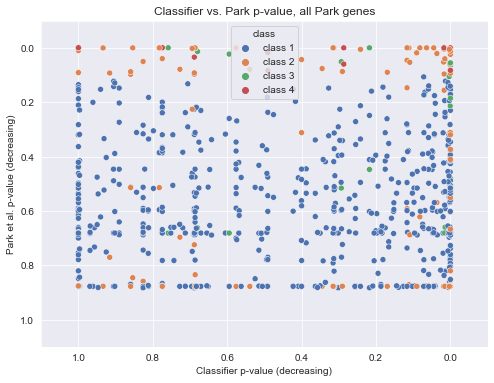

In [31]:
class_order = ['class 1', 'class 2', 'class 3', 'class 4']
sns.set({'figure.figsize': (8, 6)})
sns.scatterplot(data=pair_df, x='classifier_pval', y='park_pval',
                hue='class', hue_order=class_order)
plt.xlim(1.1, -0.1)
plt.ylim(1.1, -0.1)
plt.xlabel('Classifier p-value (decreasing)')
plt.ylabel('Park et al. p-value (decreasing)')
plt.title('Classifier vs. Park p-value, all Park genes')

Text(0.5, 1.0, 'Classifier vs. Park p-value, all Park genes')

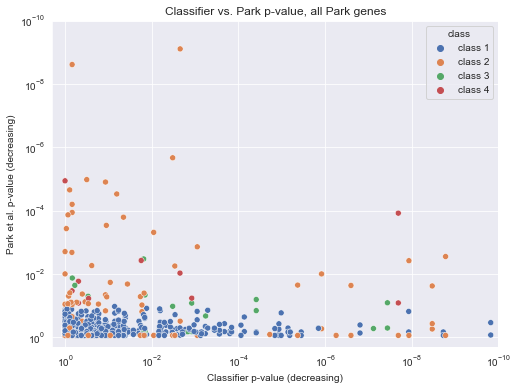

In [32]:
sns.set({'figure.figsize': (8, 6)})
sns.scatterplot(data=pair_df, x='classifier_pval', y='park_pval',
                hue='class', hue_order=class_order)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**0+1, 10**-10)
plt.ylim(10**0+1, 10**-10)
plt.xlabel('Classifier p-value (decreasing)')
plt.ylabel('Park et al. p-value (decreasing)')
plt.title('Classifier vs. Park p-value, all Park genes')

### Get classifier performance info

We also want to evaluate the classifiers themselves, to see which ones perform significantly better than with shuffled labels (similar to what we did in [the mpmp paper](https://greenelab.github.io/mpmp-manuscript/#evaluating-mutation-prediction-classifiers)). This will give us 3 different p-values:

* "Classifier performance p-value": a p-value for the t-test comparing performance of the classifier at predicting mutation presence/absence, vs shuffled baseline
* "Park p-value": the p-value from Park et al. for mutation/CNV co-occurrence
* "Classifier 'both' p-value": the p-value from a t-test comparing classifier predictions with 'one' of a mutation or CNV with 'both' a mutation and a CNV

We'll mostly use the first one (performance p-value) to filter to the genes/cancer types where classification works well, since our results don't mean much if we can't accurately distinguish between mutated and non-mutated samples.

The latter two p-values are both ways to quantify "two-hit-ness", or the degree to which the gene behaves as a "two-hit" driver in the relevant cancer type. We want to see to what extent the measurements agree, *conditional on* good classifier performance.

In [33]:
class_sig_df = ut.get_classifier_significance(pair_df.identifier.unique().tolist(), park_preds_dir)
                                              # '/home/jake/research/mpmp/data/vogelstein_preds/park_genes_old/')
print(class_sig_df.shape)
print('Significant classifiers:', class_sig_df.reject_null.sum(), '/', class_sig_df.shape[0])
class_sig_df.head(10)

(428, 5)
Significant classifiers: 185 / 428


,identifier,delta_mean,p_value,corr_pval,reject_null
0,ACVR1_UCEC,0.025644,0.111481,0.186383,False
1,ACVR2A_COADREAD,0.074114,0.288393,0.393096,False
2,ACVR2A_LIHC,0.057458,0.064565,0.121690,False
3,AJUBA_HNSC,0.082065,0.006790,0.020906,True
4,AKT1_BRCA,0.070435,0.005676,0.018403,True
5,AKT1_UCEC,0.138985,0.027607,0.061221,False
6,ALB_LIHC,-0.003750,0.906584,0.919474,False
7,AMER1_COADREAD,-0.017576,0.662770,0.721795,False
8,APC_COADREAD,0.069482,0.001856,0.007029,True
9,APC_STAD,0.106135,0.032933,0.070112,False


In [34]:
new_pair_df = pair_df.merge(
    class_sig_df.loc[:, ['identifier', 'reject_null']],
    left_on='identifier', right_on='identifier'
)
new_pair_df.rename(columns={
    'reject_null_x': 'reject_null_class_both',
    'reject_null_y': 'reject_null_class_perf'
}, inplace=True)
new_pair_df['reject_null_park'] = (new_pair_df.park_pval < 0.05)
new_pair_df.head()

,identifier,delta_mean,p_value,classifier_pval,reject_null_class_both,Gene,Tissue,Effect,Pval,park_pval,LogFDR,Target,classification,class,reject_null_class_perf,reject_null_park
0,ACVR1_UCEC,-0.228588,0.147345,0.309135,False,ACVR1,UCEC,0.000000,0.997445,0.681521,0.166514,B_Target,Oncogene,class 1,False,False
1,ACVR1_UCEC,-0.228588,0.147345,0.309135,False,ACVR1,UCEC,-0.482699,0.370095,0.571956,0.242630,B_Target,Oncogene,class 1,False,False
2,ACVR2A_COADREAD,0.133333,0.442983,0.686390,False,ACVR2A,COADREAD,0.000000,0.997631,0.681315,0.166646,B_Target,TSG,class 1,False,False
3,ACVR2A_COADREAD,0.133333,0.442983,0.686390,False,ACVR2A,COADREAD,0.187531,0.753981,0.780954,0.107369,B_Target,TSG,class 1,False,False
4,ACVR2A_LIHC,-0.323166,0.002949,0.013146,True,ACVR2A,LIHC,-1.000178,0.040008,0.122307,0.912515,B_Target,TSG,class 1,False,False


Text(0.5, 1.0, 'Classifier vs. Park p-value, "good" classifiers')

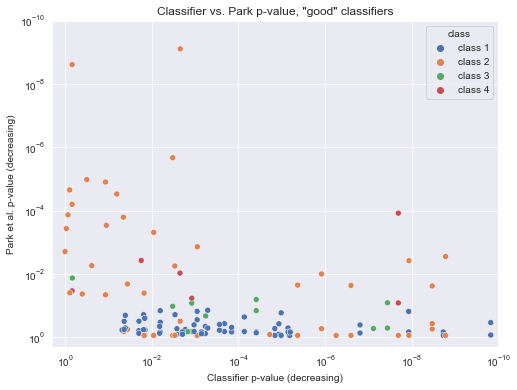

In [35]:
class_order = ['class 1', 'class 2', 'class 3', 'class 4']
sns.set({'figure.figsize': (8, 6)})
sns.scatterplot(data=new_pair_df[((new_pair_df.reject_null_park) |
                                 (new_pair_df.reject_null_class_both)) &
                                 (new_pair_df.reject_null_class_perf)],
                x='classifier_pval', y='park_pval', hue='class', hue_order=class_order)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**0+1, 10**-10)
plt.ylim(10**0+1, 10**-10)
plt.xlabel('Classifier p-value (decreasing)')
plt.ylabel('Park et al. p-value (decreasing)')
plt.title('Classifier vs. Park p-value, "good" classifiers')

Text(0.5, 0.98, 'Park et al. vs one/both statistical testing')

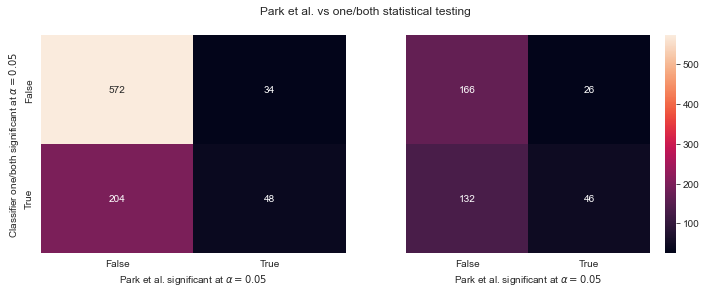

In [36]:
sns.set({'figure.figsize': (12, 4)})
fig, axarr = plt.subplots(1, 2, sharey=True)

heatmap_df = (new_pair_df
    .loc[:, ['reject_null_class_both', 'reject_null_park']]
    .copy()
    .value_counts()
    .reset_index()
    .pivot(index='reject_null_class_both', columns='reject_null_park')
)
vmax = heatmap_df.max().max()
heatmap_df.head()
sns.heatmap(heatmap_df, annot=True, fmt='d', cbar=False, ax=axarr[0])
axarr[0].set_xlabel(r'Park et al. significant at $\alpha=0.05$')
axarr[0].set_xticklabels(list(zip(*heatmap_df.columns.tolist()))[1])
axarr[0].set_ylabel(r'Classifier one/both significant at $\alpha=0.05$')
         
heatmap_df = (new_pair_df
    .loc[new_pair_df.reject_null_class_perf, ['reject_null_class_both', 'reject_null_park']]
    .copy()
    .value_counts()
    .reset_index()
    .pivot(index='reject_null_class_both', columns='reject_null_park')
)
sns.heatmap(heatmap_df, vmax=vmax, annot=True, fmt='d', ax=axarr[1])
axarr[1].set_xlabel(r'Park et al. significant at $\alpha=0.05$')
axarr[1].set_xticklabels(list(zip(*heatmap_df.columns.tolist()))[1])
axarr[1].set_ylabel('')

plt.suptitle('Park et al. vs one/both statistical testing')

In the heatmaps above, we're looking at the same data as before, but with each gene/cancer type binarized into significant/not significant for each of the two "two-hit" tests.

My interpretation of this is that our gene expression classifier-based method tends to find more significant examples (bottom left square) than the Park et al. method (top right square and bottom right square). This is the opposite of what I expected; I had thought that using gene expression would be more specific than just looking at mutation co-occurrence. We'll have to explore this more in the future, since it's a somewhat counterintuitive result.

### Count examples with sufficient "both" samples

As a next step, we're thinking about training classifiers to *directly* detect samples with two hits (i.e. a CNV and a point mutation). We want to quickly check how many genes/cancer types this would be feasible for here.

In [37]:
status_count_df = (park_info_df
  .groupby(by=['identifier', 'status'])
  .count()
  .loc[:, ['class']]
  .unstack('status')
  .fillna(0)
  .astype(int)
)
status_count_df.columns = status_count_df.columns.droplevel(0)
status_count_df.head()

status,both,none,one
identifier,,,
ACVR1_UCEC,4,646,198
ACVR2A_COADREAD,4,736,60
ACVR2A_LIHC,8,566,118
AJUBA_HNSC,16,778,172
AKT1_BRCA,20,1594,332


In [38]:
sum_df = status_count_df.sum(axis=1)
sum_df.index.rename('identifier', inplace=True)
status_prop_df = status_count_df.div(sum_df, axis=0)
status_prop_df.head()

status,both,none,one
identifier,,,
ACVR1_UCEC,0.004717,0.761792,0.233491
ACVR2A_COADREAD,0.005000,0.920000,0.075000
ACVR2A_LIHC,0.011561,0.817919,0.170520
AJUBA_HNSC,0.016563,0.805383,0.178054
AKT1_BRCA,0.010277,0.819116,0.170606


In [39]:
def valid_ixs_from_threshold(count_threshold, prop_threshold=0.05):
    valid_ixs = (status_count_df.loc[
        ((status_prop_df['both'] > prop_threshold) & (status_prop_df['none'] > prop_threshold)) &
        ((status_count_df['both'] > count_threshold) & (status_count_df['none'] > count_threshold)), :
    ]).index
    # TODO: debug classifiers causing this issue
    index_count_df = (status_count_df
        .loc[valid_ixs, :]
        .drop_duplicates(keep='first')
    )
    return (index_count_df.index, index_count_df.shape[0])

print(valid_ixs_from_threshold(5)[0][:5])
print(valid_ixs_from_threshold(5)[1])

Index(['APC_COADREAD', 'ARID1A_BLCA', 'ATRX_SARC', 'AXIN1_LIHC', 'B2M_DLBC'], dtype='object', name='identifier')
87


Text(0, 0.5, 'Number of valid genes/cancer types')

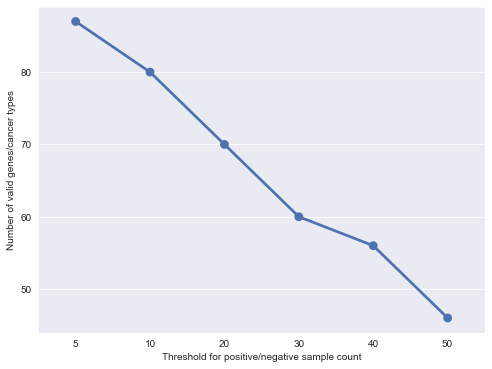

In [40]:
sns.set({'figure.figsize': (8, 6)})

thresholds = [5, 10, 20, 30, 40, 50]
line_df = pd.DataFrame([
    thresholds,
    [valid_ixs_from_threshold(t)[1] for t in thresholds]
], index=['threshold', 'valid_ixs']).T

sns.pointplot(data=line_df, x='threshold', y='valid_ixs')
plt.xlabel('Threshold for positive/negative sample count')
plt.ylabel('Number of valid genes/cancer types')

Text(0, 0.5, 'Proportion of valid genes/cancer types')

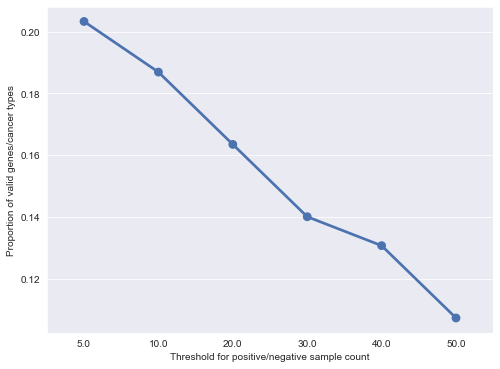

In [41]:
sns.set({'figure.figsize': (8, 6)})

thresholds = [5, 10, 20, 30, 40, 50]
line_df = pd.DataFrame([
    thresholds,
    [valid_ixs_from_threshold(t)[1] / status_count_df.shape[0] for t in thresholds]
], index=['threshold', 'valid_ixs']).T

sns.pointplot(data=line_df, x='threshold', y='valid_ixs')
plt.xlabel('Threshold for positive/negative sample count')
plt.ylabel('Proportion of valid genes/cancer types')

From these results, it seems like there are a substantial number of gene/cancer type combinations with considerable numbers of both "none" and "both" samples. This suggests that we could probably train models directly to predict whether or not a sample has two hits, at least in some cases.